In [76]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary

import numpy as np

In [2]:
DEVICE = 'cuda:1'

SEED = 0

torch.backends.cudnn.enabled = False
torch.manual_seed(SEED)
np.random.seed(SEED)

# Data

In [3]:
class IndexDataset(torch.utils.data.Dataset):
    """
    Simple wrapper to get the index of each element in the original dataset
    """
    
    def __init__(self, dataset : torch.utils.data.Dataset):
        """
        Initialization.
        
        Parameters
        ----------
        dataset
            The dataset which to wrap.
        """
        
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        outs = self.dataset[index]
        return index, *outs 

class CorruptedDataset(torch.utils.data.Dataset):
    """
    Simple wrapper to get the index of each element in the original dataset
    """
    
    def __init__(self, dataset : torch.utils.data.Dataset, mislabeled_ratio : float, random_state : int = 42):
        """
        Initialization.
        
        Parameters
        ----------
        dataset
            The dataset which to corrupt
        mislabeled_ratio
            Fraction of samples which to corrupt
        """
        
        self.dataset = dataset
        self.labels = self.dataset.targets.numpy()
        unique_labels = np.unique(self.labels)

        rng = np.random.default_rng(seed=random_state)
        self.corrupted_indices = rng.choice(np.arange(len(self.labels)), 
                                                  size=int(mislabeled_ratio*len(self.labels)),
                                                  replace=False)
        for i in self.corrupted_indices:
            label = self.labels[i]
            pool = list(unique_labels)
            pool.remove(label)
            self.labels[i] = pool[np.random.randint(len(pool))]

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        x, _ = self.dataset[index]
        
        return x, self.labels[index]

In [4]:
batch_size_train = 128
batch_size_test = 1000

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = CorruptedDataset(
    torchvision.datasets.MNIST('./files/', train=True, download=True, transform=train_transforms), 
    mislabeled_ratio=0.001,
    random_state=SEED
)
test_ds = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=test_transforms)

split_1_ds, split_2_ds = torch.utils.data.random_split(train_ds, [len(train_ds) // 2]*2)
split_1_ds = IndexDataset(split_1_ds)
split_2_ds = IndexDataset(split_2_ds)

# train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size_train, shuffle=True)

split1_loader = torch.utils.data.DataLoader(split_1_ds, batch_size=batch_size_train, shuffle=True)
split2_loader = torch.utils.data.DataLoader(split_2_ds, batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size_test, shuffle=False)

# Build Network

In [5]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1600, 128),
            nn.ReLU(),
            
            nn.Linear(128, num_classes)
        )

    def forward(self, x):

        feats = self.features(x)
        logits = self.classifier(feats)
        
        return logits


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# Training model

In [7]:
def log_sample_clf_scores(logits, target, sample_idx, sample_score_list):
    '''
        Append score of GT class to sample_score_list
    '''
    output_scores = F.softmax(logits.detach(), dim=-1).cpu()
    gt_scores = output_scores[:, target].diag()
    gt_scores = gt_scores.numpy()
    sample_score = np.hstack([sample_idx.numpy().reshape(-1, 1), gt_scores.reshape(-1, 1)])
    sample_score_list.append(sample_score)
    return sample_score_list

def log_predictions(logits, target, sample_idx, sample_pred_list):
    output_preds = F.softmax(logits.detach(), dim=-1).argmax(dim=-1).cpu().numpy()
    sample_preds = np.hstack([sample_idx.numpy().reshape(-1, 1), output_preds.reshape(-1, 1)])
    sample_pred_list.append(sample_preds)
    return sample_pred_list

def train(model, epoch, train_loader, loss_fn, log_loader=None, log_step_rel=1.0):
    model.train()
    sample_scores = []
    sample_preds = []
    train_losses = []
    train_accs = []

    if log_loader is None:
        log_loader = train_loader
        log_step = None
    else:
        log_step = int(log_step_rel * len(train_loader))

    for step, (sample_idx, data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        logits = model(data.to(DEVICE))
        loss = loss_fn(logits, target.to(DEVICE))
        loss.backward()
        optimizer.step()

        ### sample_scores calculation
        if log_step is None:
            log_sample_clf_scores(logits, target, sample_idx, sample_scores)
            log_predictions(logits, target, sample_idx, sample_preds)
        elif step % log_step == 0:
            scores_log, preds_log = test(model, log_loader)
            sample_scores.append(scores_log)
            sample_preds.append(preds_log)
            model.train()

        output_scores = F.softmax(logits.detach(), dim=-1).cpu()
        accuracy = (output_scores.argmax(dim=1) == target).sum() / target.shape[0]
        
        train_accs.append(accuracy.item())
        train_losses.append(loss.item())
    
    sample_scores = np.vstack(sample_scores)
    sample_preds = np.vstack(sample_preds)
    
    return train_losses, train_accs, sample_scores, sample_preds

In [8]:
def test(model, test_loader):
    model.eval()
    sample_scores = []
    sample_preds = []
    
    with torch.no_grad():
        for sample_idx, data, target in test_loader:
            logits = model(data.to(DEVICE))

            log_sample_clf_scores(logits, target, sample_idx, sample_scores)
            log_predictions(logits, target, sample_idx, sample_preds)

    sample_scores = np.vstack(sample_scores)
    sample_preds = np.vstack(sample_preds)
    
    return sample_scores, sample_preds

In [11]:
def LeNet(NUM_CLASSES = 10, in_channels = 1):
    return nn.Sequential(
                nn.Conv2d(in_channels, 32, 5, padding = 2), 
                nn.ReLU(), 
                nn.MaxPool2d(2, 2), 
                nn.Conv2d(32, 64, 5, padding = 2), 
                nn.ReLU(), 
                nn.MaxPool2d(2, 2), 
                nn.Flatten(), 
                nn.Linear(7*7*64, 1024), 
                nn.ReLU(), 
                nn.Linear(1024, NUM_CLASSES)
        )

# SSFT

### First Split Training

In [52]:
learning_rate = 1e-1
loss_fn = nn.CrossEntropyLoss()
n_epochs = 100

# lenet, sgd momentum 0.9, weight_decay 5e-4, cyclic LR with peak lr 0.01 (preferable) or 0.1; peak at 10th epoch
# train at max 100 epochs; stop training when 5 epochs with a 100% accuracy in a row
# EMNIST ? 
# https://github.com/pratyushmaini/ssft

model = LeNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [ ]:
from tqdm.auto import tqdm


sample_scores_by_epoch = []
sample_preds_by_epoch = []
train_losses = []
train_accs = []

for epoch in tqdm(range(1, n_epochs + 1)):
    losses, accs, sample_scores, sample_preds = train(model, epoch, split1_loader, loss_fn)
    
    train_losses.append(losses)
    train_accs.append(accs)
    sample_scores_by_epoch.append(sample_scores)
    sample_preds_by_epoch.append(sample_preds)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
step_losses = np.concatenate(train_losses)
step_accs = np.concatenate(train_accs)

epoch_losses = np.mean(train_losses, axis=1)
epoch_accs = np.mean(train_accs, axis=1)

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(epoch_accs, color='red', label='Train accuracy')
plt.axhline(1)
plt.grid()
plt.legend()

### Learning time

In [ ]:
def learning_time_from_scores(sample_scores_by_epoch, thr=0.5):
    learning_times = {}
    learning_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(sample_scores_by_epoch), total=len(sample_scores_by_epoch)):
        # Iterate over samples in the epoch
        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            
            # reset not yet learnt or forgotten samples 
            if sample_idx not in learning_times or score < thr:
                learning_times[sample_idx] = -1
                learning_times_step[sample_idx] = -1
    
            if score > thr and learning_times[sample_idx] == -1:
                learning_times[sample_idx] = epoch
                learning_times_step[sample_idx] = epoch*len(scores) + step

    return learning_times, learning_times_step

def learning_time_from_preds(sample_preds_by_epoch, dataset):
    learning_times = {}
    learning_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(sample_preds_by_epoch), total=len(sample_preds_by_epoch)):
        # Iterate over samples in the epoch
        for step, (sample_idx, pred) in enumerate(scores):
            sample_idx = int(sample_idx)
            _, _, gt = dataset[sample_idx]
#             gt = dataset.dataset.dataset.labels[sample_idx]
            
            # reset not yet learnt or forgotten samples 
            if sample_idx not in learning_times or pred != gt:
                learning_times[sample_idx] = -1
                learning_times_step[sample_idx] = -1
    
            if pred == gt and learning_times[sample_idx] == -1:
                learning_times[sample_idx] = epoch
                learning_times_step[sample_idx] = epoch*len(scores) + step

    return learning_times, learning_times_step

In [ ]:
scores_learning_times, scores_learning_times_step = learning_time_from_scores(sample_scores_by_epoch, thr=0.5)
preds_learning_times, preds_learning_times_step = learning_time_from_preds(sample_preds_by_epoch, split_1_ds)

In [ ]:
split_1_metrics_df = pd.DataFrame(
    [(idx, scores_learning_times_step[idx], preds_learning_times_step[idx]) for idx in scores_learning_times_step.keys()],
    columns = ['sample_idx', 'scores_learning_time', 'preds_learning_time']
)

# Second Split training

In [ ]:
from tqdm.auto import tqdm

n_epochs = 100

split_1_sample_scores_by_epoch = []
split_1_sample_preds_by_epoch = []
train_losses = []
train_accs = []

for epoch in tqdm(range(1, n_epochs + 1)):
    losses, accs, sample_scores, sample_preds = train(model, epoch, split2_loader, loss_fn, 
                                                      log_loader=split1_loader, log_step_rel=0.25)

    train_losses.append(losses)
    train_accs.append(accs)
    split_1_sample_scores_by_epoch.append(sample_scores)
    split_1_sample_preds_by_epoch.append(sample_preds)

In [ ]:
step_losses = np.concatenate(train_losses)
step_accs = np.concatenate(train_accs)

epoch_losses = np.mean(train_losses, axis=1)
epoch_accs = np.mean(train_accs, axis=1)

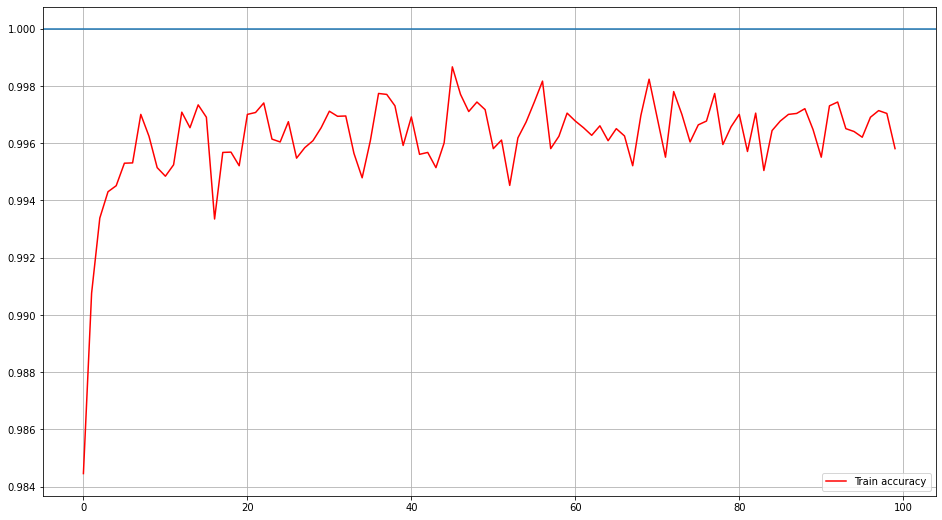

In [69]:
plt.figure(figsize=(16, 9))
plt.plot(epoch_accs, color='red', label='Train accuracy')
plt.axhline(1)
plt.grid()
plt.legend()

### Forgetting Time

In [ ]:
def forgetting_time_from_scores(split_1_sample_scores_by_epoch, dataset, thr=0.5):
    forgetting_times = {}
    forgetting_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(split_1_sample_scores_by_epoch), total=len(split_1_sample_scores_by_epoch)):
        # Iterate over samples in the epoch

        num_logs_per_epoch = len(scores) // len(dataset) - 1
        steps_per_log = len(dataset) // num_logs_per_epoch

        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            log_step = step // len(dataset)

            # reset not yet forgotten samples 
            if sample_idx not in forgetting_times or score > thr:
                forgetting_times[sample_idx] = -1
                forgetting_times_step[sample_idx] = -1
    
            if score < thr and forgetting_times[sample_idx] == -1:
                forgetting_times[sample_idx] = epoch
                forgetting_times_step[sample_idx] = (epoch*num_logs_per_epoch + log_step) * steps_per_log
    return forgetting_times, forgetting_times_step

def forgetting_time_from_preds(split_1_sample_preds_by_epoch, dataset):
    forgetting_times = {}
    forgetting_times_step = {}
    
    # Iterate over epochs
    for epoch, scores in tqdm(enumerate(split_1_sample_preds_by_epoch), total=len(split_1_sample_preds_by_epoch)):
        # Iterate over samples in the epoch

        num_logs_per_epoch = len(scores) // len(dataset) - 1
        steps_per_log = len(dataset) // num_logs_per_epoch

        for step, (sample_idx, score) in enumerate(scores):
            sample_idx = int(sample_idx)
            log_step = step // len(dataset)
#             gt = dataset.dataset.dataset.labels[sample_idx]
            _, _, gt = dataset[sample_idx]

            # reset not yet forgotten samples 
            if sample_idx not in forgetting_times or score == gt:
                forgetting_times[sample_idx] = -1
                forgetting_times_step[sample_idx] = -1
    
            if score != gt and forgetting_times[sample_idx] == -1:
                forgetting_times[sample_idx] = epoch
                forgetting_times_step[sample_idx] = (epoch*num_logs_per_epoch + log_step) * steps_per_log
    return forgetting_times, forgetting_times_step

In [ ]:
forgetting_times_scores, fogetting_times_scores_steps = forgetting_time_from_scores(split_1_sample_scores_by_epoch, split_1_ds, thr=0.5)
forgetting_times_preds, fogetting_times_preds_steps = forgetting_time_from_preds(split_1_sample_preds_by_epoch, split_1_ds)

In [ ]:
split_1_forgetting_time_df = pd.DataFrame(
    [(idx, fogetting_times_scores_steps[idx], fogetting_times_preds_steps[idx]) for idx in fogetting_times_scores_steps.keys()],
    columns = ['sample_idx', 'scores_forgetting_time', 'preds_forgetting_time']
)

# Analysis

In [78]:
to_comp = 'scores' # scores/preds
ft_metric = f'{to_comp}_forgetting_time'
lt_metric = f'{to_comp}_learning_time'

metrics_df = pd.merge(split_1_metrics_df, split_1_forgetting_time_df, on='sample_idx')
never_forgotten_thr = metrics_df[ft_metric].max() + 5000
metrics_df.loc[metrics_df[ft_metric] == -1, ft_metric] = never_forgotten_thr + 5000

In [79]:
shuffled_idx_2_original_idx = {i : x for i, x in enumerate(split_1_ds.dataset.indices)}
metrics_df['original_sample_idx'] = metrics_df.sample_idx.apply(lambda x: shuffled_idx_2_original_idx[x])

In [80]:
corrupted_indices = split_1_ds.dataset.dataset.corrupted_indices
metrics_df['is_mislabeled'] = False
metrics_df.loc[metrics_df.original_sample_idx.isin(corrupted_indices), 'is_mislabeled'] = True

In [81]:
learning_time = metrics_df[lt_metric].values
forgetting_time = metrics_df[ft_metric].values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


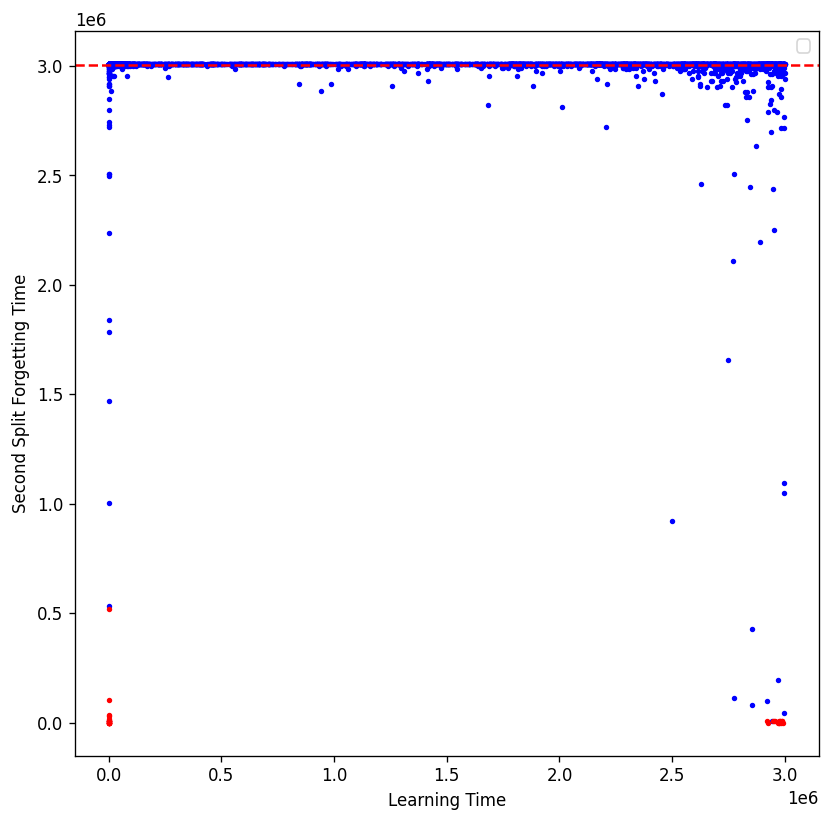

In [82]:
plt.figure(figsize=(8, 8), dpi=120)
plt.scatter(learning_time[metrics_df[~metrics_df.is_mislabeled].index], forgetting_time[metrics_df[~metrics_df.is_mislabeled].index],
            s=5, c='blue')
plt.scatter(learning_time[metrics_df[metrics_df.is_mislabeled].index], forgetting_time[metrics_df[metrics_df.is_mislabeled].index],
            s=5, c='r')
plt.axhline(y=never_forgotten_thr, linestyle='dashed', c='red')
plt.xlabel('Learning Time')
plt.ylabel('Second Split Forgetting Time')
plt.legend()
plt.show()


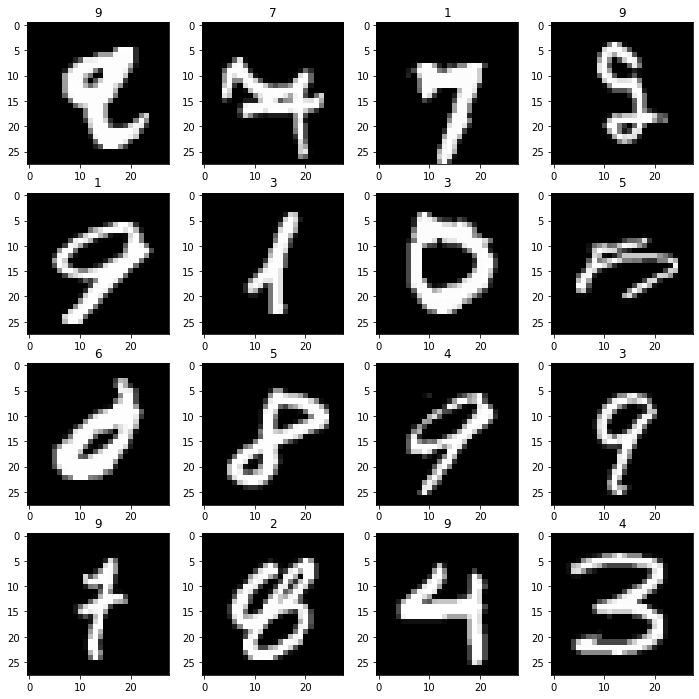

In [75]:
subset = mislabeled_subset

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
ax = ax.ravel()

for i in range(len(subset)):
    if i >= 16:
        break
    
    idx = subset[i]
    
    unnormalize = lambda x: x*0.3081 + 0.1307
    
    _, img, label = split_1_ds[idx]
    np_img = (unnormalize(img.squeeze().numpy())*255).astype(int)

    ax[i].imshow(np_img, cmap='gray')
    ax[i].set_title(label)

# TODO

1. Syntetic label flips
2. Сложить картинки и получить зашумленные картинки
3. Посмотреть корреляции с метриками
4. Уменьшить LR –> больше шагов/деталей
5. Подумать над другими метриками
6. Далее посмотреть на корреляцию с другими методами выделения аутлаеров

Главный вопрос – не надо ли форгетин тайм считать после каждых N трейн шагов, чтобы получить лучшую динамику. Сейчас просто тема со степами неправильная